In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/guitar_light/guitar_light.csv'
SAMPLES_FOLDER = '../data/guitar_light/guitar_light_samples/'
FOLDER_PREFIX = 'guitar_light'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512
N_MFCC = 20

N_EPOCHS = 1000
BATCH_SIZE = 43
VERBOSE = 1
VALIDATION = .2

RESULTS-guitar_light-2018-01-08_22:37.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

  filter_on_off disto_on_off reverb_on_off flanger_on_off delay_on_off    file
0           off          off           off            off          off  s0.wav
1           off          off            on            off          off  s1.wav
2           off          off           off             on          off  s2.wav
3           off          off            on             on          off  s3.wav
4            on          off           off            off          off  s4.wav
25 6

Training data: (25, 6)
Test data: (7, 6)

0    s0.wav
1    s1.wav
2    s2.wav
3    s3.wav
4    s4.wav
Name: file, dtype: object
25    s25.wav
26    s26.wav
27    s27.wav
28    s28.wav
29    s29.wav
Name: file, dtype: object


In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
(7, 18522)
Loaded training waveform #0
(25, 18522)


# Independent models

## Prepares the features

In [5]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(7, 20, 37)
(25, 20, 37)


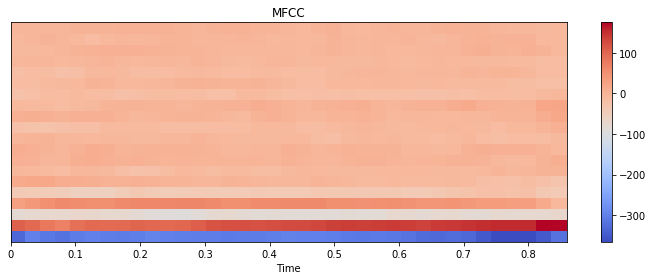

In [6]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_test_mfcc[0,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [7]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(7, 740)
(25, 740)


## Predictions

In [8]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'algo_instance_reg','algo_instance_class',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):
        print 'predicting feature', t_name
        y_train = Y_train[[t_name]].values.flatten()
        y_test = Y_test[[t_name]].values.flatten()
        print y_train.dtype
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test_mfcc)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test_mfcc)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [9]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

predicting feature filter_on_off
object
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 .............................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


In [10]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

predicting feature filter_on_off
object
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=8 ...............................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished



[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
0.92
0.857142857143
('Decision Tree', 'per_output', None, {'max_depth': 8}, 'disto_on_off', 'class', 0.92000000000000004, 0.8571428571428571)
predicting feature reverb_on_off
object
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] m

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished


In [11]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

predicting feature filter_on_off
object
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=most_frequent ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
0.52
0.428571428571
('Naive', 'per_output', None, {'strategy': 'most_frequent'}, 'filter_on_off', 'class', 0.52000000000000002, 0.42857142857142855)
predicting feature disto_on_off
object
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=m

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [12]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling

In [13]:

def target_info(df_y):
    infos = {}
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

# Preps input data
X_train_mfcc = X_train_mfcc.reshape([X_train_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)
X_test_mfcc = X_test_mfcc.reshape([X_test_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)


print ''
print X_train_mfcc.shape
print X_test_mfcc.shape

filter_on_off
disto_on_off
reverb_on_off
flanger_on_off
delay_on_off
{'filter_on_off': {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}, 'delay_on_off': {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}, 'disto_on_off': {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}, 'flanger_on_off': {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}, 'reverb_on_off': {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}}

(25, 37, 20)
(7, 37, 20)


In [16]:
def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1
                
        else:
            raise ValueError
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, model):
    
    # Prepares input and output data
    X_mean = np.mean(X_train_mfcc, axis=(0))
    X_sd = np.std(X_train_mfcc, axis=(0))
    
    X_train = (X_train_mfcc - X_mean) / X_sd
    X_test  = (X_test_mfcc - X_mean) / X_sd
    
    Y_dict_train = format_output(Y_train)
    Y_dict_test  = format_output(Y_test)
    
    # Trains the model
    hist = model.fit(X_train, Y_dict_train, 
              epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
             validation_split = VALIDATION)
    
    # Makes predictions
    pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    # Gets validation and test scores (for each metric)
    Y = {}
    for j, Y_pred in enumerate(pred):
        t_name = Y_info.keys()[j]
        t_infos = Y_info[t_name]
        
        print t_name
        print Y_pred.shape

        if t_infos['type'] == 'float64':
            test_metric = 'reg'
            Y_pred = Y_pred.flatten()
            y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
            y_pred = y_pred.tolist()
            test_score = mean_absolute_error(y_pred, Y_test[t_name])
        
        elif t_infos['type'] == 'object':
            test_metric = 'class'
            y_i = np.argmax(Y_pred, axis=1)
            y_pred = [t_infos['int2char'][y] for y in y_i]
            test_score = accuracy_score(y_pred, Y_test[t_name])

        else:
            raise ValueError
        
        #train_scores = hist.history[t_name + '_loss'][-1]
        train_scores = -1 * hist.history['loss'][-1]
        out = (label, 'joint', params1, params2,
               t_name, test_metric, train_scores, test_score)
        print out
        with open(RESULTS_FILE, 'a') as f:
            writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow(out)

        Y[t_name] = y_pred
    
    Y = pd.DataFrame(Y)
    return Y

In [17]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten
from keras.models import Model

def MLP(n_hidden_units, n_layers):
    # Input layer
    in_shape = (X_test_mfcc.shape[1],X_test_mfcc.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [8,16,32,64]:
        model = MLP(N_UNITS, N_LAYERS)
        out = test_model('MLP', N_UNITS, N_LAYERS, model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 740)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            5928        flatten_2[0][0]                  
__________________________________________________________________________________________________
filter_on_off (Dense)           (None, 2)            18          dense_2[0][0]                    
__________________________________________________________________________________________________
delay_on_o

Train on 22 samples, validate on 3 samples
Epoch 1/10
22/22 [==============================] - 1s 67ms/step - loss: 5.0977 - filter_on_off_loss: 0.8153 - delay_on_off_loss: 0.7793 - disto_on_off_loss: 1.3403 - flanger_on_off_loss: 1.0487 - reverb_on_off_loss: 1.1141 - val_loss: 5.5148 - val_filter_on_off_loss: 0.6189 - val_delay_on_off_loss: 1.9382 - val_disto_on_off_loss: 1.4836 - val_flanger_on_off_loss: 0.2621 - val_reverb_on_off_loss: 1.2120
Epoch 2/10
22/22 [==============================] - 0s 473us/step - loss: 4.0641 - filter_on_off_loss: 0.5150 - delay_on_off_loss: 0.5993 - disto_on_off_loss: 1.1656 - flanger_on_off_loss: 0.8535 - reverb_on_off_loss: 0.9307 - val_loss: 5.1275 - val_filter_on_off_loss: 0.3548 - val_delay_on_off_loss: 1.7650 - val_disto_on_off_loss: 1.4816 - val_flanger_on_off_loss: 0.2604 - val_reverb_on_off_loss: 1.2657
Epoch 3/10
22/22 [==============================] - 0s 318us/step - loss: 3.2693 - filter_on_off_loss: 0.3431 - delay_on_off_loss: 0.4397 - di

Epoch 4/10
22/22 [==============================] - 0s 228us/step - loss: 1.8800 - filter_on_off_loss: 0.2603 - delay_on_off_loss: 0.4269 - disto_on_off_loss: 0.3622 - flanger_on_off_loss: 0.4558 - reverb_on_off_loss: 0.3748 - val_loss: 2.4009 - val_filter_on_off_loss: 0.1697 - val_delay_on_off_loss: 0.2276 - val_disto_on_off_loss: 1.5632 - val_flanger_on_off_loss: 0.3383 - val_reverb_on_off_loss: 0.1021
Epoch 5/10
22/22 [==============================] - 0s 249us/step - loss: 1.4663 - filter_on_off_loss: 0.2152 - delay_on_off_loss: 0.3397 - disto_on_off_loss: 0.2752 - flanger_on_off_loss: 0.3356 - reverb_on_off_loss: 0.3007 - val_loss: 2.3897 - val_filter_on_off_loss: 0.1062 - val_delay_on_off_loss: 0.2297 - val_disto_on_off_loss: 1.6662 - val_flanger_on_off_loss: 0.2896 - val_reverb_on_off_loss: 0.0979
Epoch 6/10
22/22 [==============================] - 0s 224us/step - loss: 1.1884 - filter_on_off_loss: 0.1885 - delay_on_off_loss: 0.2727 - disto_on_off_loss: 0.2203 - flanger_on_off_l

Epoch 8/10
22/22 [==============================] - 0s 280us/step - loss: 0.3714 - filter_on_off_loss: 0.0275 - delay_on_off_loss: 0.0672 - disto_on_off_loss: 0.0653 - flanger_on_off_loss: 0.1244 - reverb_on_off_loss: 0.0871 - val_loss: 2.8509 - val_filter_on_off_loss: 0.0509 - val_delay_on_off_loss: 0.4454 - val_disto_on_off_loss: 1.1321 - val_flanger_on_off_loss: 0.2427 - val_reverb_on_off_loss: 0.9798
Epoch 9/10
22/22 [==============================] - 0s 305us/step - loss: 0.2921 - filter_on_off_loss: 0.0186 - delay_on_off_loss: 0.0542 - disto_on_off_loss: 0.0523 - flanger_on_off_loss: 0.0939 - reverb_on_off_loss: 0.0730 - val_loss: 2.8093 - val_filter_on_off_loss: 0.0392 - val_delay_on_off_loss: 0.4267 - val_disto_on_off_loss: 1.1335 - val_flanger_on_off_loss: 0.2492 - val_reverb_on_off_loss: 0.9608
Epoch 10/10
7/7 [==============================] - 0s 31ms/step
filter_on_off
(7, 2)
('MLP', 'joint', 64, 1, 'filter_on_off', 'class', -0.2327289879322052, 1.0)
delay_on_off
(7, 2)
('M

7/7 [==============================] - 0s 25ms/step
filter_on_off
(7, 2)
('MLP', 'joint', 8, 2, 'filter_on_off', 'class', -2.8132493495941162, 0.2857142857142857)
delay_on_off
(7, 2)
('MLP', 'joint', 8, 2, 'delay_on_off', 'class', -2.8132493495941162, 0.14285714285714285)
disto_on_off
(7, 2)
('MLP', 'joint', 8, 2, 'disto_on_off', 'class', -2.8132493495941162, 0.2857142857142857)
flanger_on_off
(7, 2)
('MLP', 'joint', 8, 2, 'flanger_on_off', 'class', -2.8132493495941162, 1.0)
reverb_on_off
(7, 2)
('MLP', 'joint', 8, 2, 'reverb_on_off', 'class', -2.8132493495941162, 0.2857142857142857)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
flatten_7 (Fl

Train on 22 samples, validate on 3 samples
Epoch 1/10
22/22 [==============================] - 2s 94ms/step - loss: 5.0408 - filter_on_off_loss: 0.8604 - delay_on_off_loss: 1.6131 - disto_on_off_loss: 0.9296 - flanger_on_off_loss: 0.9000 - reverb_on_off_loss: 0.7377 - val_loss: 2.2808 - val_filter_on_off_loss: 0.3439 - val_delay_on_off_loss: 0.1465 - val_disto_on_off_loss: 0.6230 - val_flanger_on_off_loss: 0.5628 - val_reverb_on_off_loss: 0.6047
Epoch 2/10
22/22 [==============================] - 0s 737us/step - loss: 4.1098 - filter_on_off_loss: 0.6819 - delay_on_off_loss: 1.3071 - disto_on_off_loss: 0.8076 - flanger_on_off_loss: 0.6817 - reverb_on_off_loss: 0.6315 - val_loss: 2.3174 - val_filter_on_off_loss: 0.3058 - val_delay_on_off_loss: 0.1270 - val_disto_on_off_loss: 0.6525 - val_flanger_on_off_loss: 0.6073 - val_reverb_on_off_loss: 0.6247
Epoch 3/10
22/22 [==============================] - 0s 902us/step - loss: 3.5093 - filter_on_off_loss: 0.5805 - delay_on_off_loss: 1.1254 - di

Epoch 4/10
22/22 [==============================] - 0s 266us/step - loss: 2.1657 - filter_on_off_loss: 0.4020 - delay_on_off_loss: 0.4648 - disto_on_off_loss: 0.4835 - flanger_on_off_loss: 0.4544 - reverb_on_off_loss: 0.3610 - val_loss: 2.0075 - val_filter_on_off_loss: 0.0992 - val_delay_on_off_loss: 0.2276 - val_disto_on_off_loss: 0.4171 - val_flanger_on_off_loss: 1.0053 - val_reverb_on_off_loss: 0.2583
Epoch 5/10
22/22 [==============================] - 0s 301us/step - loss: 1.7320 - filter_on_off_loss: 0.2876 - delay_on_off_loss: 0.3681 - disto_on_off_loss: 0.4107 - flanger_on_off_loss: 0.3729 - reverb_on_off_loss: 0.2927 - val_loss: 1.9961 - val_filter_on_off_loss: 0.0729 - val_delay_on_off_loss: 0.2207 - val_disto_on_off_loss: 0.4263 - val_flanger_on_off_loss: 1.0189 - val_reverb_on_off_loss: 0.2572
Epoch 6/10
22/22 [==============================] - 0s 302us/step - loss: 1.4095 - filter_on_off_loss: 0.2119 - delay_on_off_loss: 0.3008 - disto_on_off_loss: 0.3436 - flanger_on_off_l

In [18]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers):
    # Input layer
    in_shape = (X_test_mfcc.shape[1],X_test_mfcc.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq)(h_layer)
        
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [4,8,16,32,64,128,256]:
        model = modLSTM(N_UNITS, N_LAYERS)
        out = test_model('LSTM', N_UNITS, N_LAYERS, model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 37, 20)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 8)            928         input_10[0][0]                   
__________________________________________________________________________________________________
filter_on_off (Dense)           (None, 2)            18          lstm_1[0][0]                     
__________________________________________________________________________________________________
delay_on_off (Dense)            (None, 2)            18          lstm_1[0][0]                     
__________________________________________________________________________________________________
disto_on_o

Train on 22 samples, validate on 3 samples
Epoch 1/10
22/22 [==============================] - 2s 110ms/step - loss: 3.6807 - filter_on_off_loss: 0.6992 - delay_on_off_loss: 0.8748 - disto_on_off_loss: 0.6897 - flanger_on_off_loss: 0.6194 - reverb_on_off_loss: 0.7976 - val_loss: 3.2084 - val_filter_on_off_loss: 0.4571 - val_delay_on_off_loss: 0.7775 - val_disto_on_off_loss: 0.6147 - val_flanger_on_off_loss: 0.6248 - val_reverb_on_off_loss: 0.7344
Epoch 2/10
22/22 [==============================] - 0s 2ms/step - loss: 3.6456 - filter_on_off_loss: 0.6918 - delay_on_off_loss: 0.8593 - disto_on_off_loss: 0.6851 - flanger_on_off_loss: 0.6164 - reverb_on_off_loss: 0.7930 - val_loss: 3.1913 - val_filter_on_off_loss: 0.4516 - val_delay_on_off_loss: 0.7689 - val_disto_on_off_loss: 0.6087 - val_flanger_on_off_loss: 0.6307 - val_reverb_on_off_loss: 0.7315
Epoch 3/10
22/22 [==============================] - 0s 2ms/step - loss: 3.5993 - filter_on_off_loss: 0.6823 - delay_on_off_loss: 0.8390 - disto

Epoch 5/10
22/22 [==============================] - 0s 2ms/step - loss: 3.4677 - filter_on_off_loss: 0.6162 - delay_on_off_loss: 0.7278 - disto_on_off_loss: 0.7046 - flanger_on_off_loss: 0.7194 - reverb_on_off_loss: 0.6996 - val_loss: 3.6694 - val_filter_on_off_loss: 0.6434 - val_delay_on_off_loss: 1.0076 - val_disto_on_off_loss: 0.6639 - val_flanger_on_off_loss: 0.7534 - val_reverb_on_off_loss: 0.6011
Epoch 6/10
22/22 [==============================] - 0s 2ms/step - loss: 3.3995 - filter_on_off_loss: 0.6026 - delay_on_off_loss: 0.7059 - disto_on_off_loss: 0.6927 - flanger_on_off_loss: 0.7120 - reverb_on_off_loss: 0.6864 - val_loss: 3.6546 - val_filter_on_off_loss: 0.6371 - val_delay_on_off_loss: 0.9946 - val_disto_on_off_loss: 0.6629 - val_flanger_on_off_loss: 0.7571 - val_reverb_on_off_loss: 0.6028
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 3.3333 - filter_on_off_loss: 0.5891 - delay_on_off_loss: 0.6849 - disto_on_off_loss: 0.6810 - flanger_on_off_loss: 0

Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 2.5431 - filter_on_off_loss: 0.4537 - delay_on_off_loss: 0.4700 - disto_on_off_loss: 0.5080 - flanger_on_off_loss: 0.6379 - reverb_on_off_loss: 0.4734 - val_loss: 3.1751 - val_filter_on_off_loss: 0.4243 - val_delay_on_off_loss: 0.6230 - val_disto_on_off_loss: 0.7594 - val_flanger_on_off_loss: 0.7623 - val_reverb_on_off_loss: 0.6060
Epoch 10/10
7/7 [==============================] - 1s 80ms/step
filter_on_off
(7, 2)
('LSTM', 'joint', 64, 1, 'filter_on_off', 'class', -2.45186448097229, 0.8571428571428571)
delay_on_off
(7, 2)
('LSTM', 'joint', 64, 1, 'delay_on_off', 'class', -2.45186448097229, 0.7142857142857143)
disto_on_off
(7, 2)
('LSTM', 'joint', 64, 1, 'disto_on_off', 'class', -2.45186448097229, 0.2857142857142857)
flanger_on_off
(7, 2)
('LSTM', 'joint', 64, 1, 'flanger_on_off', 'class', -2.45186448097229, 0.7142857142857143)
reverb_on_off
(7, 2)
('LSTM', 'joint', 64, 1, 'reverb_on_off', 'class', -2.4518644809722

Train on 22 samples, validate on 3 samples
Epoch 1/10
22/22 [==============================] - 5s 213ms/step - loss: 3.7089 - filter_on_off_loss: 0.7622 - delay_on_off_loss: 0.7255 - disto_on_off_loss: 0.6995 - flanger_on_off_loss: 0.6999 - reverb_on_off_loss: 0.8219 - val_loss: 3.5272 - val_filter_on_off_loss: 0.7053 - val_delay_on_off_loss: 0.7032 - val_disto_on_off_loss: 0.6786 - val_flanger_on_off_loss: 0.6384 - val_reverb_on_off_loss: 0.8017
Epoch 2/10
22/22 [==============================] - 0s 4ms/step - loss: 3.6886 - filter_on_off_loss: 0.7585 - delay_on_off_loss: 0.7224 - disto_on_off_loss: 0.6987 - flanger_on_off_loss: 0.6939 - reverb_on_off_loss: 0.8151 - val_loss: 3.5263 - val_filter_on_off_loss: 0.7031 - val_delay_on_off_loss: 0.7049 - val_disto_on_off_loss: 0.6798 - val_flanger_on_off_loss: 0.6402 - val_reverb_on_off_loss: 0.7983
Epoch 3/10
22/22 [==============================] - 0s 3ms/step - loss: 3.6685 - filter_on_off_loss: 0.7550 - delay_on_off_loss: 0.7193 - disto

Epoch 4/10
22/22 [==============================] - 0s 4ms/step - loss: 3.4493 - filter_on_off_loss: 0.6855 - delay_on_off_loss: 0.7423 - disto_on_off_loss: 0.6593 - flanger_on_off_loss: 0.6846 - reverb_on_off_loss: 0.6777 - val_loss: 3.6001 - val_filter_on_off_loss: 0.7088 - val_delay_on_off_loss: 0.7761 - val_disto_on_off_loss: 0.6687 - val_flanger_on_off_loss: 0.5987 - val_reverb_on_off_loss: 0.8478
Epoch 5/10
22/22 [==============================] - 0s 3ms/step - loss: 3.4189 - filter_on_off_loss: 0.6808 - delay_on_off_loss: 0.7282 - disto_on_off_loss: 0.6570 - flanger_on_off_loss: 0.6812 - reverb_on_off_loss: 0.6717 - val_loss: 3.5939 - val_filter_on_off_loss: 0.7052 - val_delay_on_off_loss: 0.7762 - val_disto_on_off_loss: 0.6667 - val_flanger_on_off_loss: 0.6025 - val_reverb_on_off_loss: 0.8432
Epoch 6/10
22/22 [==============================] - 0s 4ms/step - loss: 3.3893 - filter_on_off_loss: 0.6762 - delay_on_off_loss: 0.7147 - disto_on_off_loss: 0.6547 - flanger_on_off_loss: 0

Epoch 7/10
22/22 [==============================] - 0s 4ms/step - loss: 2.9808 - filter_on_off_loss: 0.4691 - delay_on_off_loss: 0.5740 - disto_on_off_loss: 0.6476 - flanger_on_off_loss: 0.6472 - reverb_on_off_loss: 0.6429 - val_loss: 3.2306 - val_filter_on_off_loss: 0.4516 - val_delay_on_off_loss: 0.6652 - val_disto_on_off_loss: 0.6927 - val_flanger_on_off_loss: 0.8230 - val_reverb_on_off_loss: 0.5981
Epoch 8/10
22/22 [==============================] - 0s 4ms/step - loss: 2.9187 - filter_on_off_loss: 0.4455 - delay_on_off_loss: 0.5588 - disto_on_off_loss: 0.6397 - flanger_on_off_loss: 0.6423 - reverb_on_off_loss: 0.6323 - val_loss: 3.2173 - val_filter_on_off_loss: 0.4343 - val_delay_on_off_loss: 0.6688 - val_disto_on_off_loss: 0.6935 - val_flanger_on_off_loss: 0.8333 - val_reverb_on_off_loss: 0.5874
Epoch 9/10
22/22 [==============================] - 0s 4ms/step - loss: 2.8578 - filter_on_off_loss: 0.4225 - delay_on_off_loss: 0.5441 - disto_on_off_loss: 0.6317 - flanger_on_off_loss: 0

Epoch 10/10
7/7 [==============================] - 1s 180ms/step
filter_on_off
(7, 2)
('LSTM', 'joint', 64, 2, 'filter_on_off', 'class', -2.2662496566772461, 1.0)
delay_on_off
(7, 2)
('LSTM', 'joint', 64, 2, 'delay_on_off', 'class', -2.2662496566772461, 0.2857142857142857)
disto_on_off
(7, 2)
('LSTM', 'joint', 64, 2, 'disto_on_off', 'class', -2.2662496566772461, 0.7142857142857143)
flanger_on_off
(7, 2)
('LSTM', 'joint', 64, 2, 'flanger_on_off', 'class', -2.2662496566772461, 1.0)
reverb_on_off
(7, 2)
('LSTM', 'joint', 64, 2, 'reverb_on_off', 'class', -2.2662496566772461, 0.5714285714285714)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 37, 20)       0                                            
__________________________________________________________________________________________________
lstm_1

In [19]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers):
    # Input layer
    in_shape = (X_test_mfcc.shape[1],X_test_mfcc.shape[2])
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W)(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters)(h_layer_pool)
    
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer_full)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer_full)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [8,16,32]:
    for N_LAYERS in [1,2]:
        model = modConvo(N_FILTERS, N_LAYERS)
        out = test_model('Conv', N_FILTERS, N_LAYERS, model)

(37, 20)
0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 37, 20)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 34, 8)        648         input_20[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 16, 8)        0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 8)            0           max_pooling1d_1[0][0]            
__________________________________________________________________________________________________

Train on 22 samples, validate on 3 samples
Epoch 1/10
22/22 [==============================] - 6s 258ms/step - loss: 5.1549 - filter_on_off_loss: 0.8379 - delay_on_off_loss: 0.9613 - disto_on_off_loss: 0.6697 - flanger_on_off_loss: 1.1764 - reverb_on_off_loss: 1.5095 - val_loss: 6.6354 - val_filter_on_off_loss: 0.4497 - val_delay_on_off_loss: 1.4327 - val_disto_on_off_loss: 0.5670 - val_flanger_on_off_loss: 1.3502 - val_reverb_on_off_loss: 2.8359
Epoch 2/10
22/22 [==============================] - 0s 368us/step - loss: 4.8663 - filter_on_off_loss: 0.7992 - delay_on_off_loss: 0.9501 - disto_on_off_loss: 0.6681 - flanger_on_off_loss: 1.0870 - reverb_on_off_loss: 1.3619 - val_loss: 6.2211 - val_filter_on_off_loss: 0.4334 - val_delay_on_off_loss: 1.4047 - val_disto_on_off_loss: 0.5728 - val_flanger_on_off_loss: 1.2253 - val_reverb_on_off_loss: 2.5849
Epoch 3/10
22/22 [==============================] - 0s 338us/step - loss: 4.5028 - filter_on_off_loss: 0.7507 - delay_on_off_loss: 0.9355 - d

Epoch 3/10
22/22 [==============================] - 0s 506us/step - loss: 6.0452 - filter_on_off_loss: 1.1955 - delay_on_off_loss: 0.9096 - disto_on_off_loss: 1.8270 - flanger_on_off_loss: 1.1208 - reverb_on_off_loss: 0.9923 - val_loss: 8.4431 - val_filter_on_off_loss: 2.0148 - val_delay_on_off_loss: 2.2970 - val_disto_on_off_loss: 1.2711 - val_flanger_on_off_loss: 2.5657 - val_reverb_on_off_loss: 0.2945
Epoch 4/10
22/22 [==============================] - 0s 343us/step - loss: 5.7412 - filter_on_off_loss: 1.1267 - delay_on_off_loss: 0.8863 - disto_on_off_loss: 1.7322 - flanger_on_off_loss: 1.0476 - reverb_on_off_loss: 0.9484 - val_loss: 8.1864 - val_filter_on_off_loss: 1.9249 - val_delay_on_off_loss: 2.2655 - val_disto_on_off_loss: 1.1363 - val_flanger_on_off_loss: 2.5784 - val_reverb_on_off_loss: 0.2814
Epoch 5/10
22/22 [==============================] - 0s 351us/step - loss: 5.4208 - filter_on_off_loss: 1.0540 - delay_on_off_loss: 0.8613 - disto_on_off_loss: 1.6298 - flanger_on_off_l

Epoch 4/10
22/22 [==============================] - 0s 389us/step - loss: 3.4787 - filter_on_off_loss: 0.5025 - delay_on_off_loss: 0.6261 - disto_on_off_loss: 0.7192 - flanger_on_off_loss: 1.0831 - reverb_on_off_loss: 0.5478 - val_loss: 3.2473 - val_filter_on_off_loss: 0.4273 - val_delay_on_off_loss: 0.8557 - val_disto_on_off_loss: 0.4532 - val_flanger_on_off_loss: 1.0888 - val_reverb_on_off_loss: 0.4223
Epoch 5/10
22/22 [==============================] - 0s 377us/step - loss: 3.1314 - filter_on_off_loss: 0.4591 - delay_on_off_loss: 0.6063 - disto_on_off_loss: 0.6585 - flanger_on_off_loss: 0.9081 - reverb_on_off_loss: 0.4993 - val_loss: 3.2062 - val_filter_on_off_loss: 0.3992 - val_delay_on_off_loss: 0.8833 - val_disto_on_off_loss: 0.4361 - val_flanger_on_off_loss: 1.1039 - val_reverb_on_off_loss: 0.3838
Epoch 6/10
22/22 [==============================] - 0s 425us/step - loss: 2.8314 - filter_on_off_loss: 0.4213 - delay_on_off_loss: 0.5870 - disto_on_off_loss: 0.6073 - flanger_on_off_l

Epoch 6/10
22/22 [==============================] - 0s 388us/step - loss: 2.9127 - filter_on_off_loss: 0.6231 - delay_on_off_loss: 0.5282 - disto_on_off_loss: 0.6414 - flanger_on_off_loss: 0.5171 - reverb_on_off_loss: 0.6030 - val_loss: 4.0346 - val_filter_on_off_loss: 0.9753 - val_delay_on_off_loss: 1.0969 - val_disto_on_off_loss: 0.6468 - val_flanger_on_off_loss: 0.8382 - val_reverb_on_off_loss: 0.4775
Epoch 7/10
22/22 [==============================] - 0s 397us/step - loss: 2.6727 - filter_on_off_loss: 0.5541 - delay_on_off_loss: 0.4902 - disto_on_off_loss: 0.6005 - flanger_on_off_loss: 0.4687 - reverb_on_off_loss: 0.5592 - val_loss: 3.9053 - val_filter_on_off_loss: 0.8458 - val_delay_on_off_loss: 1.1124 - val_disto_on_off_loss: 0.6001 - val_flanger_on_off_loss: 0.8895 - val_reverb_on_off_loss: 0.4574
Epoch 8/10
22/22 [==============================] - 0s 635us/step - loss: 2.4712 - filter_on_off_loss: 0.4962 - delay_on_off_loss: 0.4560 - disto_on_off_loss: 0.5668 - flanger_on_off_l

Epoch 7/10
22/22 [==============================] - 0s 679us/step - loss: 2.1360 - filter_on_off_loss: 0.2068 - delay_on_off_loss: 0.4411 - disto_on_off_loss: 0.5346 - flanger_on_off_loss: 0.4260 - reverb_on_off_loss: 0.5275 - val_loss: 2.8308 - val_filter_on_off_loss: 0.0825 - val_delay_on_off_loss: 0.8674 - val_disto_on_off_loss: 0.4390 - val_flanger_on_off_loss: 1.0148 - val_reverb_on_off_loss: 0.4270
Epoch 8/10
22/22 [==============================] - 0s 723us/step - loss: 1.9424 - filter_on_off_loss: 0.1565 - delay_on_off_loss: 0.4299 - disto_on_off_loss: 0.5070 - flanger_on_off_loss: 0.3681 - reverb_on_off_loss: 0.4809 - val_loss: 2.9369 - val_filter_on_off_loss: 0.0655 - val_delay_on_off_loss: 0.9187 - val_disto_on_off_loss: 0.4838 - val_flanger_on_off_loss: 1.0593 - val_reverb_on_off_loss: 0.4096
Epoch 9/10
22/22 [==============================] - 0s 490us/step - loss: 1.7710 - filter_on_off_loss: 0.1187 - delay_on_off_loss: 0.4087 - disto_on_off_loss: 0.4801 - flanger_on_off_l

# Visualizing the results

/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: filter(): dplyr, stats
lag():    dplyr, stats

  warnings.warn(x, RRuntimeWarning)


  algo  type algo_instance_reg algo_instance_class train_score
1 Conv joint                32                   2   -1.612020
2 LSTM joint               128                   2   -1.302034
3  MLP joint                64                   1   -0.232729
           algo metric     score
1          Conv  class 0.5714286
2 Decision Tree  class 0.7714286
3          LSTM  class 0.7428571
4           MLP  class 0.8000000
5         Naive  class 0.2571429
6           kNN  class 0.5714286


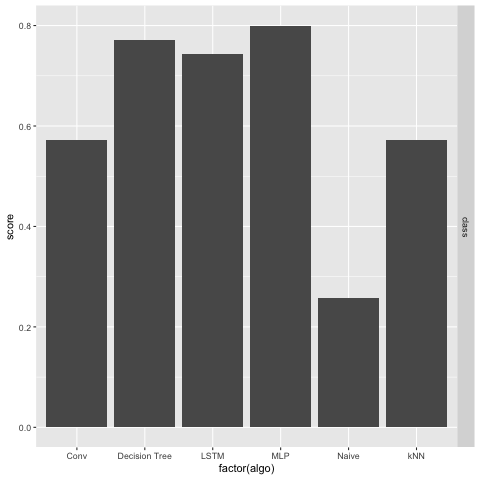

In [20]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, algo_instance_reg, algo_instance_class) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","algo_instance_reg","algo_instance_class")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p
